# Desafio: Detecção de anomalias em imagens médicas usando CNN

In [ ]:
import urllib.request
import tarfile
import os

links = [
    'https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz'
]

for idx, link in enumerate(links):
    fn_zip = 'images_%02d.tar.gz' % (idx + 1)
    fn_extracted = 'images_%02d' % (idx + 1)

    print('Downloading ' + fn_zip + '...')
    urllib.request.urlretrieve(link, fn_zip)

    print('Extracting ' + fn_zip + '...')
    with tarfile.open(fn_zip, 'r:gz') as tar:
        tar.extractall(fn_extracted)

    os.remove(fn_zip)

print("Download and extraction complete. Please check the extracted folders.")


### Import e organização do dataset

In [ ]:
import numpy as np
import pandas as pd
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
all_xray_df = pd.read_csv('/content/Data_Entry_2017_v2020.csv')
all_image_paths = {os.path.basename(x): x for x in
                   glob(os.path.join('/content', 'images_01', 'images', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df['Patient Age'] = all_xray_df['Patient Age'].map(lambda x: int(x))
all_xray_df.sample(3)

Scans found: 0 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path
53579,00013531_023.png,Infiltration,23,13531,51,M,AP,2500,2048,0.168,0.168,None
70020,00017236_102.png,Infiltration,102,17236,46,M,AP,2500,2048,0.168,0.168,None
98837,00026132_017.png,Infiltration,17,26132,29,M,AP,3056,2544,0.139,0.139,None


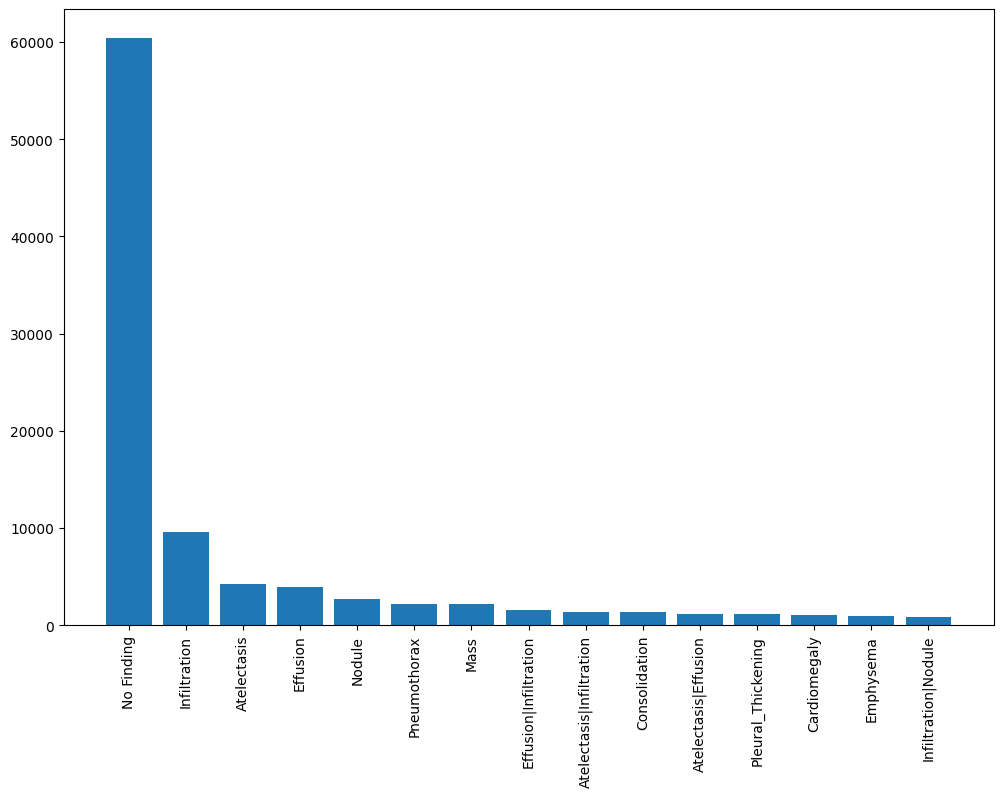

In [ ]:
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [ ]:
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1:
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
66515,00016441_000.png,,0,16441,56,F,PA,2526,2433,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
108769,00029514_003.png,Effusion,3,29514,29,M,AP,3056,2544,0.139,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80618,00019792_000.png,Infiltration,0,19792,64,F,PA,2358,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


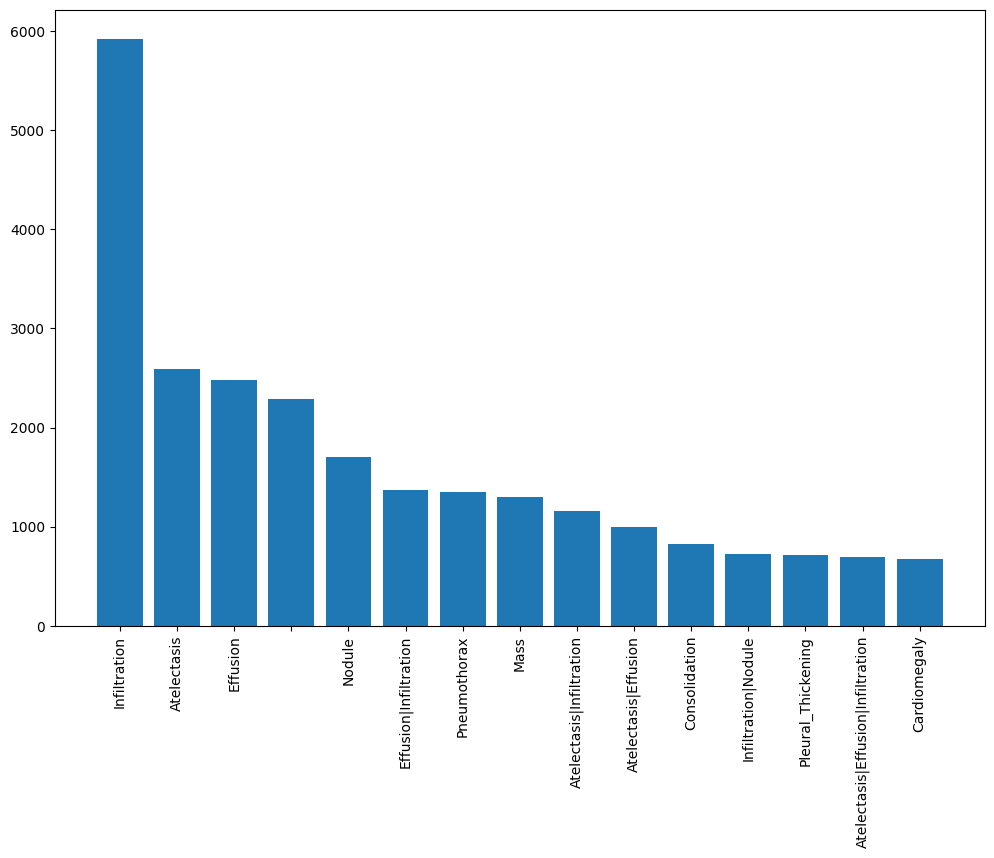

In [ ]:
sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
all_xray_df = all_xray_df.sample(40000, weights=sample_weights)

label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

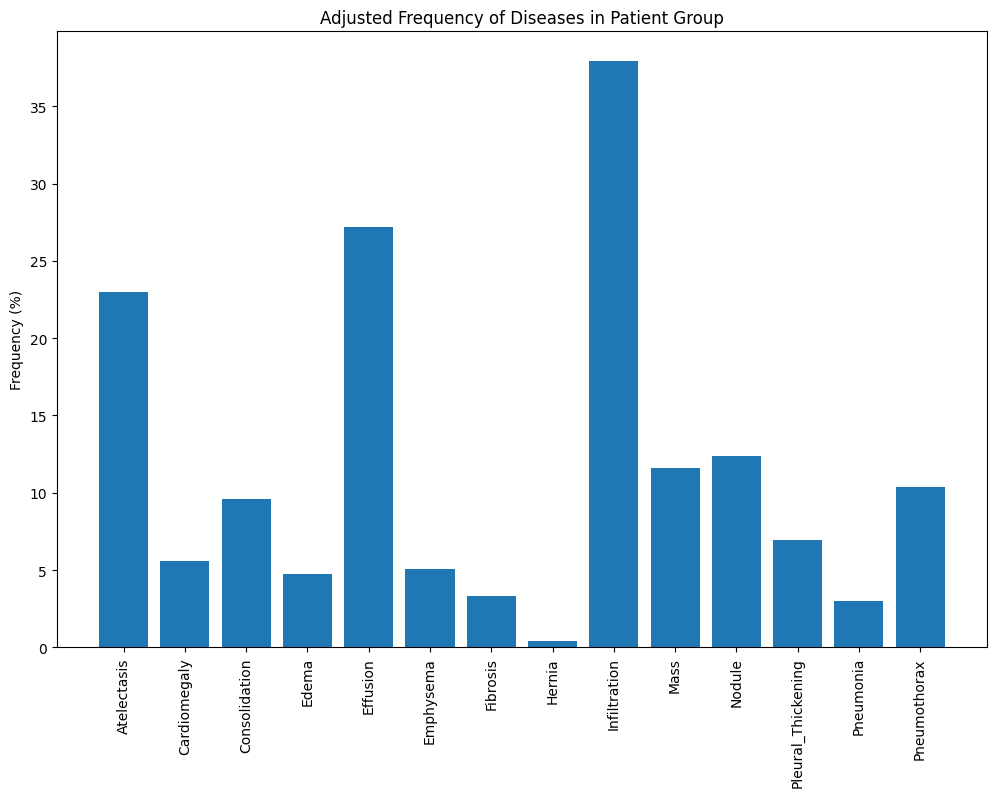

In [ ]:
label_counts = 100*np.mean(all_xray_df[all_labels].values,0)
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(all_labels, rotation = 90)
ax1.set_title('Adjusted Frequency of Diseases in Patient Group')
_ = ax1.set_ylabel('Frequency (%)')

### Gerador de data e Treino

In [ ]:
all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [ ]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(all_xray_df,
                                   test_size = 0.25,
                                   random_state = 2018,
                                   stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 30000 validation 10000


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (128, 128)
core_idg = ImageDataGenerator(samplewise_center=True,
                              samplewise_std_normalization=True,
                              horizontal_flip = True,
                              vertical_flip = False,
                              height_shift_range= 0.05,
                              width_shift_range=0.1,
                              rotation_range=5,
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [ ]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir,
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = ''
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen


In [ ]:
train_gen = flow_from_dataframe(core_idg, train_df,
                             path_col = 'path',
                            y_col = 'disease_vec',
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 32)

valid_gen = flow_from_dataframe(core_idg, valid_df,
                             path_col = 'path',
                            y_col = 'disease_vec',
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 256)

test_X, test_Y = next(flow_from_dataframe(core_idg,
                               valid_df,
                             path_col = 'path',
                            y_col = 'disease_vec',
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 1024))


In [ ]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y)
                             if n_score>0.5]))
    c_ax.axis('off')

In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
base_mobilenet_model = MobileNet(input_shape =  t_x.shape[1:],
                                 include_top = False, weights = None)
multi_disease_model = Sequential()
multi_disease_model.add(base_mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(all_labels), activation = 'sigmoid'))
multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
multi_disease_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functi  (None, 4, 4, 1024)        3228288   
 onal)                                                           
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 14)                7

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=3)
callbacks_list = [checkpoint, early]

In [ ]:
history = multi_disease_model.fit_generator(train_gen,
                                  steps_per_epoch=100,
                                  validation_data = (test_X, test_Y),
                                  epochs = 1,
                                  callbacks = callbacks_list)

In [ ]:
score = multi_disease_model.evaluate(test_X, test_Y, verbose=0)
print("Accuracy after one epoch: " + str(round(score[1]*100,2)) + "%")

In [ ]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

In [ ]:
steps_per_epoch = 100,
validation_data =  (test_X, test_Y),
epochs = 5,
callbacks = callbacks_list

In [ ]:
print(history_multiple_epochs.history.keys())
#str(history.history['loss',])
#plt.subplot(211)
print(history_multiple_epochs.history)
print(callbacks_list)
plt.plot(history_multiple_epochs.history['val_loss'])
plt.plot(history_multiple_epochs.history['loss'])
plt.plot(history_multiple_epochs.history['val_binary_accuracy'])
plt.plot(history_multiple_epochs.history['binary_accuracy'])
plt.plot(history_multiple_epochs.history['val_mean_absolute_error'])
plt.plot(history_multiple_epochs.history['mean_absolute_error'])
#plt.title('model accuracy')
#plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [ ]:
multi_disease_model.load_weights(weight_path)

In [ ]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

In [ ]:
for c_label, p_count, t_count in zip(all_labels,
                                     100*np.mean(pred_Y,0),
                                     100*np.mean(test_Y,0)):
    print('%s: Dx: %2.2f%%, PDx: %2.2f%%' % (c_label, t_count, p_count))

In [ ]:
print(inception_history.history.keys())
#str(history.history['loss',])
plt.subplot(211)
#print(inception_history.history)
#print(callbacks_list)
plt.plot(inception_history.history['val_loss'])
plt.plot(inception_history.history['loss'])
#plt.plot(inception_history.history['binary_accuracy'])
#plt.title('model accuracy')
#plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#plt.subplot(221)
plt.plot(inception_history.history['val_acc'])
plt.plot(inception_history.history['acc'])
#plt.plot(inception_history.history['binary_accuracy'])
#plt.title('model accuracy')
#plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [ ]:
inception_score = multi_disease_inception_model.evaluate(test_X, test_Y, verbose=0)
print("Accuracy for inception model after epochs: " + str(round(inception_score[1]*100,2)) + "%")